In [1]:
import cv2
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft, irfft
import numpy as np

In [ ]:
%cd /content/drive/MyDrive/НОД ВШЭ/2 семестр/Анализ изображения

In [3]:
img = cv2.imread('Егор.jpg')

In [4]:
img_size = 640
window_size = 100
sigma = 5

## Метод быстрого преобразования Фурье

 $$\text{Прямая свёртка имеетсложность } O(n^2) \text{ что является достаточно трудоёмким процессом.  }$$ $$ \text{Для ускорения алгоритма предлагется переход из пространственной области в частотный, используя быстрое преобразование Фурье, чья сложностьравна } O(nLog(n))$$
 $$ \text{опираясь на теорему о свёртке, гласящая свёртка в простраственной области равна фильтрации в частотной,   } $$ 
 $$\text{можно сперва перейти в частотную область, выполнить фильтрацию, затем обратно перейти в пространственную область, }$$ 
 $$\text{ таки мобразом получив сложность алгортма раную } O(nLog(n)) $$

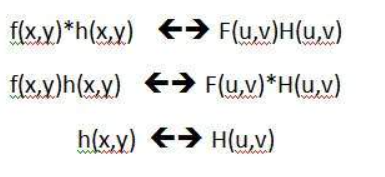

---



In [5]:
# получение гауссовского ядра
def get_kernel(window_size, sigma):
  t = np.linspace(-3*sigma, 3*sigma, window_size)
  bump = np.exp(-0.1*t**2)
  norm_sigma = np.exp(-0.1*sigma**2)
  bump /= np.trapz(bump) # normalize the integral to 1
  return bump, norm_sigma

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [7]:
kernel, norm_sigma = get_kernel(window_size, sigma)

In [8]:
def fft_conv(gray, kernel, window_size):
  img_pad = np.pad(gray, ((0, window_size-1)))
  kernel_pad = np.pad(kernel, (0, gray.shape[1]-1))
  # переход в частотную область
  img_ft = fft(img_pad)
  kernel_fft = fft(kernel_pad)
  restored_img = ifft(img_ft*kernel_fft).real[int(window_size/2) :gray.shape[0], int(window_size//2):gray.shape[1]]
  return restored_img

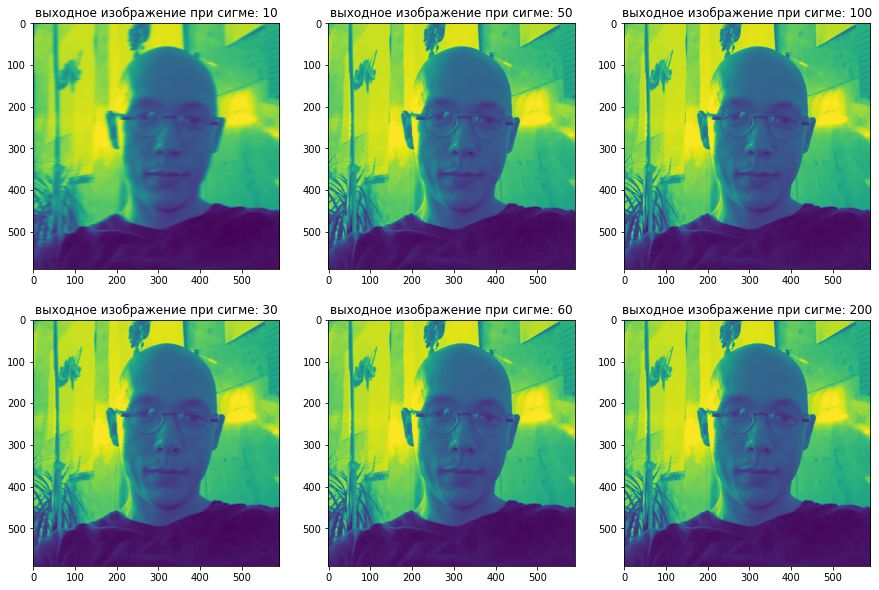

In [9]:
figure, axis = plt.subplots(2, 3, figsize=(15, 10))
idx = 0
idy = 0
for i in [10, 30, 50, 60, 100, 200]:
  window_size = 100

  kernel, norm_sigma = get_kernel(window_size, i)
  axis[idx, idy].imshow(fft_conv(gray, kernel, window_size))
  axis[idx, idy].set_title(f'выходное изображение при сигме: {i}')
  if idx >= 1:
    idy += 1
    idx = 0
  else:
    idx += 1
  
plt.show()

Можно заметить, что при больших сигмах, еффект от свёртки почти никакой

## Полиномиальная свёртка

Не смотря на эффективность БПФ, существует более быстрая реализация свёртки через полиномы

Каждый полином можно разложить на взвешенную сумму степеней, т.е. задача сводится к вычислению сверток с константой, с линейной функцией x, с x^2 и т.д. При этом важно, чтобы число участков в кусочно-линейной аппроксимации и число степеней было невелико.


Действуя по индукции, можно получить слудующее

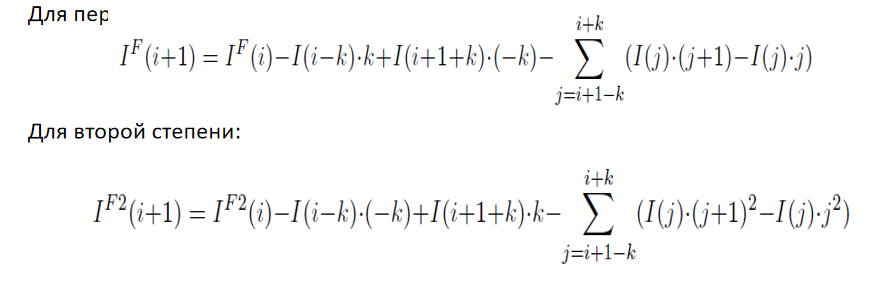

In [13]:
def polynom_conv(image, kernel, sigma):
  k = len(kernel) // 2

  x_g = np.array([i for i in range(len(kernel))]) - k

  # разделение ядра на 3 отрезка
  x_less = np.where(kernel < sigma)[0]
  x_1 = x_less[:int(x_less.shape[0]/2)]
  x_2 = np.where(kernel >= sigma)[0]
  x_3 = x_less[int(x_less.shape[0]/2):]

  gauss_part1 = kernel[x_1]
  gauss_part2 = kernel[x_2]
  gauss_part3 = kernel[x_3]

  # апроксимация ядра методом наименьщих квадратов
  approximated_gauss1 = np.polyfit(x_1,gauss_part1 , 2)
  approximated_gauss2 = np.polyfit(x_2,gauss_part2 , 2)
  approximated_gauss3 = np.polyfit(x_3,gauss_part3 , 2)

  # создание базы для каждой степени
  convol_main_0 = np.zeros(image.shape)
  convol_main_1 = np.zeros(image.shape)
  convol_main_2 = np.zeros(image.shape)

  I_Fn = np.pad(image, ((0, 0),(k, k)))

  # процесс свёртки
  for idx, apprx  in enumerate([approximated_gauss1, approximated_gauss2, approximated_gauss3]):
    w_2, w_1, w_0 = apprx

    if idx == 0:
      k1 = 0
      k2 = gauss_part1.shape[0]
      shift1 = 0
      shift2 = -(2*k - (k2 - k1))

    if idx == 1:
      k1 = gauss_part2.shape[0]
      k2 = gauss_part1.shape[0] + gauss_part2.shape[0]
      shift1 = k1
      shift2 = -k1 + 1

    if idx == 2:
      k1 = gauss_part1.shape[0] + gauss_part2.shape[0]
      k2 = 2 * k + 1
      shift1 = k1
      shift2 = 1
    
        
    c_first = np.sum(I_Fn[:, k1:k2], axis=1)


    # быстрая свёртка для нулевой степени
    conv_0 = [c_first]
    sums_0 = [np.zeros(640)]

    for i in range(k, I_Fn.shape[1] - k - 1):
      sum_0 = c_first - I_Fn[:, i - k + shift1]
      c = sum_0 + I_Fn[:, i + k + shift2]
      sums_0.append(sum_0)
      conv_0.append(c)
      c_first = c


    conv_0 = np.array([w_0 * i for i in conv_0])
    sums_0 = np.array(sums_0)

    
    
    y_1 = np.array([i for i in range(k1 - k, k2 - k)])
    c_first = np.sum(y_1*I_Fn[:,k1:k2], axis=1)


    conv_1 = [c_first]
    sums_1 = [np.zeros(640)]



    # быстрая свёртка для линейной отображения
    for i in range(k, I_Fn.shape[1] - k - 1):
        sum_1 = c_first - I_Fn[:, i - k + shift1] * y_1[0] - sums_0[i - k]
        c = sum_1 + I_Fn[:, i + k + shift2] * y_1[-1]
        sums_1.append(sum_1)
        conv_1.append(c)
        c_first = c

    conv_1 = np.array([w_1 * i for i in conv_1])
    sums_1 = np.array(sums_1)


    # быстрая свёртка для квадратичного отображения
    y_2 = np.array([i ** 2 for i in range(k1 - k, k2 - k)])

    c_first = np.sum(y_2*I_Fn[:,k1:k2], axis=1)
    conv_2 = [c_first]

    for i in range(k, I_Fn.shape[1] - k - 1):
        c = c_first - I_Fn[:, i - k + shift1] * y_2[0] + I_Fn[:, i + k + shift2] * y_2[-1] - \
            2 * sums_1[:, i - k] - sums_0[i - k]
        conv_2.append(c)
        c_first = c

    conv_2 = np.array([w_2 * i for i in conv_2])

    # нормализация
    c0_max = np.squeeze(conv_0).max()
    c0_min = np.squeeze(conv_0).min()

    c1_max = np.squeeze(conv_1).max()
    c1_min = np.squeeze(conv_1).min()

    c2_max = np.squeeze(conv_2).max()
    c2_min = np.squeeze(conv_2).min()

    # результат свёртки для нулевой степени
    convol_main_0 = convol_main_0 + np.squeeze(conv_0).T
    # результат свёртки для линейного отображения
    convol_main_1 = convol_main_1 +  (np.squeeze(conv_0).T - c0_min)/(c0_max - c0_min) + (np.squeeze(conv_1).T - c1_min)/(c1_max - c1_min)
    # для квадратичного
    convol_main_2 = convol_main_2 +  (np.squeeze(conv_0).T - c0_min)/(c0_max - c0_min) + (np.squeeze(conv_1).T - c1_min)/(c1_max - c1_min) + \
      (np.squeeze(conv_2).T - c2_min)/(c2_max - c2_min)
    
    

  return convol_main_0,convol_main_1, convol_main_2

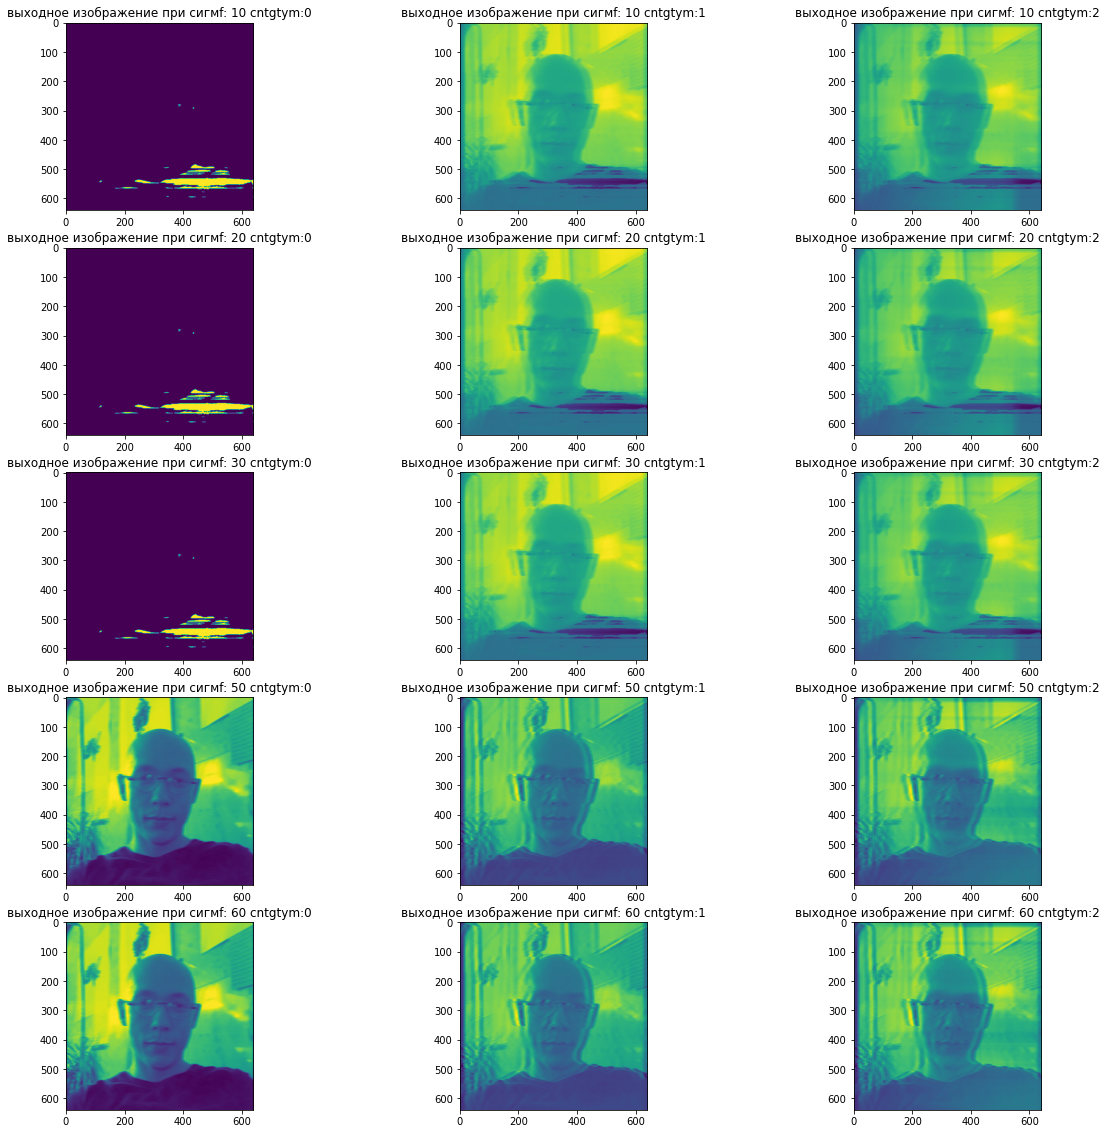

In [12]:
figure, axis = plt.subplots(5, 3, figsize=(20, 20))
idx = 0
idy = 0
window_size = 40
for i in [10, 20, 30, 50, 60]:
  

  kernel, norm_sigma = get_kernel(window_size, i)
  degree_0, degree_1, degree_2 = polynom_conv(gray, kernel,norm_sigma)
  axis[idx, 0].imshow(1 - degree_0)
  axis[idx, 0].set_title(f'выходное изображение при сигмf: {i} cntgtym:{0}')

  axis[idx, 1].imshow(degree_1)
  axis[idx, 1].set_title(f'выходное изображение при сигмf: {i} cntgtym:{1}')

  axis[idx, 2].imshow(degree_2)
  axis[idx, 2].set_title(f'выходное изображение при сигмf: {i} cntgtym:{2}')
  idx += 1

  
plt.show()

Можно заметить, что качество свёрки на порядок ниже, чем при ПБФ. Это можно объяснить через ошибку при аппроксимации. Особенно, при нулевой степени, качество результата сильно  зависит от сигмы, хотя при определённых сигмах, качество лучше чем отображение с высшими степенями.